In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [13]:
# There are 70,000 images, each with 784 features (28x28 pixels)
X, y = mnist["data"], mnist["target"]



print(X.shape)  # should print (70000, 784)
print(y.shape)  # should print (70000,)


(70000, 784)
(70000,)


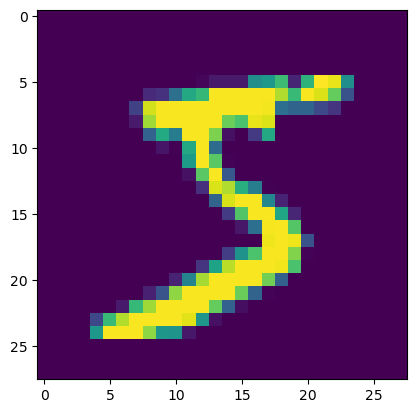

'5'

In [27]:
#Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, 
#reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:
import matplotlib as mpl
import matplotlib.pyplot as plt
index = 0
# Get the first image (row) using iloc
some_digit = X.iloc[index]  # ✅ fix here
some_digit_image = some_digit.to_numpy().reshape(28, 28)  # reshape to 2D image
plt.imshow(some_digit_image)
plt.show()
#now lets just verify it 
y[index]

In [31]:
#note that the output of y is a string it should be a number so lets just cast it to integer
import numpy as np
y = y.astype(np.uint8)
y[0]

np.uint8(5)

In [32]:
#lets create the test examples and the train examples
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [34]:
#now just simplicity just add the training data for 5
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)
y_train_5[2]

np.False_

In [35]:
# Import the SGDClassifier from scikit-learn's linear_model module
from sklearn.linear_model import SGDClassifier

# Create an instance of SGDClassifier
# - SGD stands for Stochastic Gradient Descent
# - It is a linear classifier (like logistic regression or linear SVM) trained using SGD
# - It's great for large datasets because it updates the model incrementally, one training instance at a time
# - Setting random_state ensures reproducibility (you get the same results every time)
sgd_clf = SGDClassifier(random_state=42)

# Train the classifier on the training set
# - X_train should contain the pixel values of the images (each row is one 28x28 image flattened into 784 features)
# - y_train_5 is the binary label array: True if the digit is 5, False otherwise
# - This makes it a binary classification problem: "Is this a 5?" -> Yes (True) or No (False)
# - The fit() function trains the model by adjusting the weights to minimize the classification error
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [36]:
sgd_clf.predict([some_digit])

/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [44]:
from sklearn.model_selection import cross_val_score

# Evaluate the SGD classifier using cross-validation
# cross_val_score() splits the training data into 'cv' number of folds (in this case, 3 folds)
# It trains the model on (cv-1) parts and evaluates it on the remaining part, rotating this process
# This way, it gives you a more reliable estimate of the model's performance on unseen data

# Arguments:
# - sgd_clf: the classifier object you've already trained (SGDClassifier in this case)
# - X_train: the input features (flattened pixel values of images)
# - y_train_5: binary labels (True if digit is 5, else False)
# - cv=3: number of folds for cross-validation (3 in this case)
# - scoring="accuracy": the performance metric you want to evaluate; here it measures what percentage of predictions were correct

accuracy_scores=cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Accuracy on each fold:", accuracy_scores)


Accuracy on each fold: [0.95035 0.96035 0.9604 ]


In [45]:
from sklearn.base import BaseEstimator

# Define a custom classifier that inherits from BaseEstimator (a Scikit-learn requirement for compatibility)
class Never5Classifier(BaseEstimator):
    
    # The fit method is required by all estimators in Scikit-learn
    # This classifier doesn't learn anything, so it simply returns itself
    def fit(self, X, y=None):
        return self

    # The predict method must return predictions for each input sample
    # Here, we are returning an array of 'False' values — meaning "this is not a 5"
    # This classifier will ALWAYS predict that the input is NOT a 5
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [46]:
# Create an instance of the custom dummy classifier
never_5_clf = Never5Classifier()

# Evaluate the classifier using cross-validation
# This will split the training data into 3 folds
# For each fold, it trains the classifier on 2 parts and tests on the remaining part
# Since our classifier always predicts "not 5", it will perform well on accuracy
# — but only because "5" is rare in the dataset (class imbalance)
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

In [47]:
from sklearn.model_selection import cross_val_predict

# This function performs cross-validation just like cross_val_score,
# but instead of returning evaluation scores (e.g., accuracy),
# it returns the *predicted labels* for each input instance in the training set.
# Each prediction is made by a model that was trained *without* seeing that specific instance.
# This gives us fair predictions that we can use to evaluate the classifier reliably.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [48]:
from sklearn.metrics import confusion_matrix

# The confusion_matrix() compares the actual labels (y_train_5)
# with the predicted labels (y_train_pred) to see how many were classified correctly or incorrectly.
# It returns a 2x2 matrix for binary classification:
# Rows = actual classes, Columns = predicted classes

# Structure of the matrix:
#     Predicted Not-5    Predicted 5
#     -------------------------------
# A:  Actual Not-5  -->  True Negatives (TN)    False Positives (FP)
# B:  Actual 5      -->  False Negatives (FN)   True Positives (TP)

# So from the matrix:
# - TN = correctly predicted not-5
# - FP = predicted 5 but actually not-5
# - FN = predicted not-5 but actually 5
# - TP = correctly predicted 5

conf_matrix = confusion_matrix(y_train_5, y_train_pred)
print(conf_matrix)

# Example output:
# array([[53057,  1522],    <- Row 1: Actual Not-5
#        [ 1325,  4096]])   <- Row 2: Actual 5

# Interpretation:
# - 53,057 true negatives: not-5s correctly identified as not-5
# - 1,522 false positives: not-5s wrongly predicted as 5
# - 1,325 false negatives: 5s wrongly predicted as not-5
# - 4,096 true positives: 5s correctly identified as 5


[[53892   687]
 [ 1891  3530]]


In [50]:
#Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1522)
print(recall_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1325)

0.8370879772350012
0.6511713705958311


In [51]:
#recall =TP/TP + FN
#precision =TP/TP + FP
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
#f1_score = True precision/tp+((false positive +false_negative)/2)

0.7325171197343847

In [52]:
#                Predicted
#              |   5   |  Not-5 |
#        ------------------------
#Actual |  5   |  TP   |   FN   |
#       | Not-5|  FP   |   TN   |
#f1_score is balance between prescision and recall
#now lets just set some thresholds for 
# Use the classifier’s decision_function() instead of predict() to get the raw decision score
# This score reflects how confident the model is about the prediction
# Positive scores indicate the model thinks the instance belongs to the positive class (digit 5 in this case)
# Negative scores suggest the instance likely belongs to the negative class (not a 5)

y_scores = sgd_clf.decision_function([some_digit])  # Get the decision score for the input instance

# Example output: array([2412.53175101])
# This means the model is quite confident this is a digit 5 (since the score is high and positive)

threshold = 0  # Default threshold used internally by SGDClassifier: predicts True if score > 0

# Manually apply the threshold to make a prediction
y_some_digit_pred = (y_scores > threshold)  # Returns True if the score is above the threshold

# Output: array([ True])
# So the model predicts this digit is a 5 (positive class)


NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [53]:
# By default, SGDClassifier uses a threshold of 0 — if the decision score is greater than 0, it predicts True (i.e., "digit is 5")

# Let's try increasing the threshold to make the classifier more "strict"
# Now it will only predict True (digit is 5) if the confidence (score) is above 8000

threshold = 8000  # Much higher threshold than default

# Apply the new threshold to the previously obtained decision score
y_some_digit_pred = (y_scores > threshold)

# Output: array([False])
# Even though the digit is actually a 5, the classifier now predicts False (not a 5) 
# because the score (2412.53) is not high enough to pass this new threshold

# This demonstrates a key tradeoff:
# - Increasing the threshold decreases recall (the classifier misses more actual 5s)
# - You're being more cautious, but that comes at the cost of detecting fewer true positives


NameError: name 'y_scores' is not defined